---
title: "Ensemble of Confidence Intervals"
author: "Damien Martin"
date: "2024-05-11 13:00"
categories: [data-vis, plotnine, gallery]
image: "image.jpg"
description: "Make a plot with confidence intervals, and infeasible regions shaded out"
---

This shows how to create a plot of Monte Carlo'ed confidence intervals. In this particular problem, we know that the parameter we are estimating -- earliest time to failure (ETTF) -- cannot be greater than the smallest failure time in the data set.

The data set shows:
- The true value of ETTF as a dashed line
- The value of the smallest data point (dot)
- The confidence interval
- Shades the region of values higher than the smallest value, as an experimenter in this regieme would know this is an infeasible regieme for the ETTF.

Shows how to shade a region, and remove the background grid points / borders / etc.

The model in this case is to use data to estimate the ETTF $\Theta$, where the probability of failure follows the distribution 

$$ p(t) = \exp(-(t-\Theta)) \text{ if }t > \Theta,\text{ 0 otherwise}$$

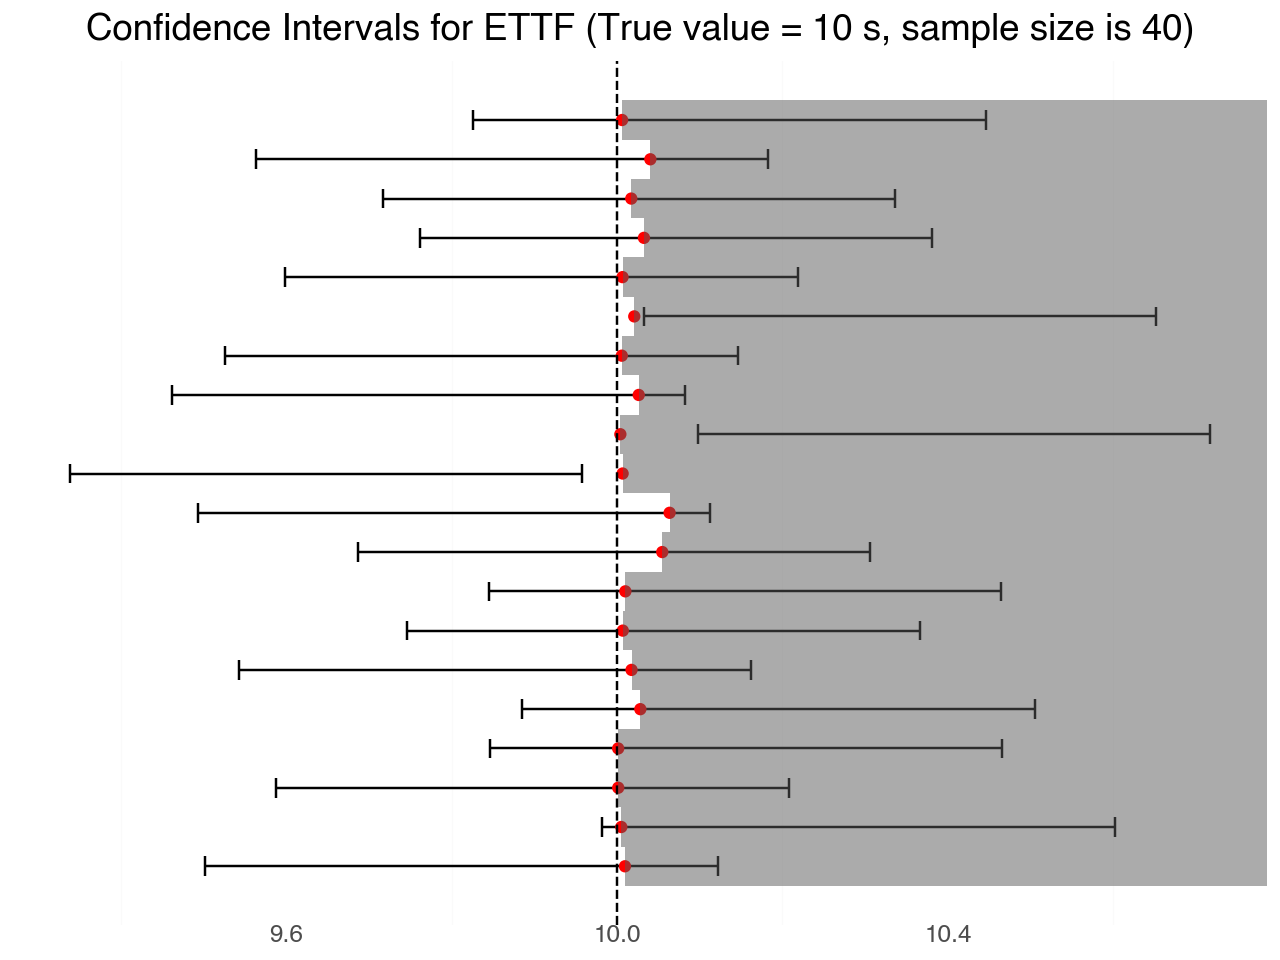

In [6]:
#| code-fold: true

import numpy as np
import plotnine as p9
import pandas as pd


np.random.seed(26)

THETA = 10
N_SIM = 20
SAMPLE_SIZE = 40

worlds = THETA + np.random.exponential(size=(SAMPLE_SIZE, N_SIM))
means = worlds.mean(axis=0)
smallest = worlds.min(axis=0)

# intervals for Theta
ci_lower = (means - 1) - 1.96*1/np.sqrt(SAMPLE_SIZE)
ci_upper = (means - 1) + 1.96*1/np.sqrt(SAMPLE_SIZE)

# How often is THETA in the CI?
value_in_ci =  ((ci_lower<=THETA) & (THETA <= ci_upper)).mean()
# How often do we some infeasible values?
# Here means the ci_upper is greater than the lowest value in the data set
has_some_infeasible = (ci_upper > smallest).mean()
# How often is the entire CI infeasible (meaning we know from the data set
# that the value logically cannot be in the interval)
entire_ci_infeasible = (ci_lower > smallest).mean()

plot_data = pd.DataFrame({'lower': ci_lower, 'upper': ci_upper, 'smallest': smallest}).reset_index()
title = f"Confidence Intervals for ETTF (True value = 10 s, sample size is {SAMPLE_SIZE})"
(
    p9.ggplot(
        plot_data, 
        p9.aes(y='index')
    )
    + p9.geom_errorbarh(mapping=p9.aes(xmin='lower', xmax='upper'))
    + p9.geom_point(mapping=p9.aes(x='smallest'), color='red')
    + p9.labs(x="", y="", title=title)
    + p9.geom_vline(xintercept=THETA, linetype="dashed")
    + p9.theme_bw()
    + p9.theme(
        axis_ticks=p9.element_blank(),
        panel_grid_major=p9.element_blank(),
        panel_border=p9.element_blank(),
    )
    + p9.scale_y_continuous(breaks=[])
    + p9.geom_rect(
        mapping=p9.aes(xmax=float('inf'), xmin='smallest', ymin='index-0.5', ymax='index+0.5'), 
        alpha=0.5
    )
)